In [1]:
from xml.dom.minidom import parse
import xml.dom.minidom
import latlng
import math

DOMTree = xml.dom.minidom.parse("boston.xml")
collection = DOMTree.documentElement

nodes = collection.getElementsByTagName("node")
ways = collection.getElementsByTagName("way")


In [2]:
nodes_ll = {}
print(len(nodes))
for node in nodes:
    lat = float(node.getAttribute("lat"))
    lng = float(node.getAttribute("lon"))
    nodes_ll[node.getAttribute("id")] = (lat, lng)

18463


In [3]:
print(len(ways))

3048


In [4]:
def get_latlng(ref):
    return nodes_ll[ref]

class node:
    
    def __init__(self, nd):
        self.nd = nd
        self.ref = nd.getAttribute("ref")
        ll = get_latlng(self.ref)
        self.lat = ll[0]
        self.lng = ll[1]

class road:
    
    def __init__(self, way, category):
        self.way = way
        self.category = category
        self.nodes = []
        for nd in way.getElementsByTagName("nd"):
            self.nodes.append(node(nd))
    
    def get_distance(self, lat, lng):
        l = len(self.nodes)
        d = 0
        mdis = 99999999999
        md = 0
        for i in range(1,l):
            p1 = latlng.Cartesian(0,0)
            p2 = latlng.LatLng(lat,lng).get_xy(latlng.LatLng(self.nodes[i-1].lat, self.nodes[i-1].lng))
            p3 = latlng.LatLng(lat,lng).get_xy(latlng.LatLng(self.nodes[i].lat, self.nodes[i].lng))
            k = ( (p1.x - p2.x)*(p3.x - p2.x) + (p1.y - p2.y)*(p3.y - p2.y) ) / \
                ( (p3.x - p2.x)**2 + (p3.y - p2.y)**2 )
            foot = latlng.Cartesian(p2.x + k*(p3.x - p2.x), p2.y + k*(p3.y - p2.y))
            if p2.x <= foot.x and foot.x <= p3.x and p2.y <= foot.y and foot.y <= p3.y:
                d += math.sqrt( (p2.x-foot.x)**2 + (p2.y-foot.y)**2 )
                dis = math.sqrt( foot.x**2 + foot.y**2 )
                if dis < mdis:
                    mdis = dis
                    md = d
            else:
                d += math.sqrt( (p2.x-p3.x)**2 + (p2.y-p3.y)**2 )
        return (mdis, md)
        

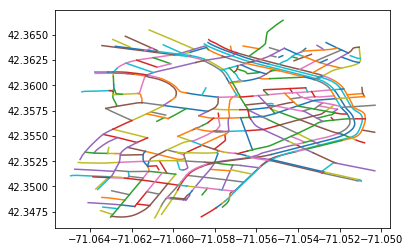

In [16]:
import matplotlib.pyplot as plt

roads = []

for way in ways:
    ndx = []
    ndy = []
    for tag in way.getElementsByTagName("tag"):
        if tag.getAttribute("k") == "highway"\
        and (tag.getAttribute("v")=="motorway"\
        or tag.getAttribute("v")=="trunk"\
        or tag.getAttribute("v")=="primary"\
        or tag.getAttribute("v")=="secondary"\
        or tag.getAttribute("v")=="tertiary"\
        or tag.getAttribute("v")=="unclassified"\
        or tag.getAttribute("v")=="residential"):
            r = road(way, tag.getAttribute("v"))
            l = len(r.nodes)
            flag = True
            for i in range(l):
                if r.nodes[i].lng > -71.05 \
                or (r.nodes[i].lat < 42.35 and r.nodes[i].lng > -71.055) \
                or r.nodes[i].lat < 42.345 \
                or r.nodes[i].lng < -71.065:
                    flag = False
                    break
                else:
                    ndx.append(r.nodes[i].lng)
                    ndy.append(r.nodes[i].lat)
            if flag:
                plt.plot(ndx, ndy)
                roads.append(r)
            break
plt.show()

In [6]:
##### generate new xml file
# doc = xml.dom.minidom.Document()
# root = doc.createElement('roads')
# doc.appendChild(root)
# for r in roads:
#     road = doc.createElement('road')
#     road.setAttribute('category',r.category)
#     for node in r.nodes:
#         nd = doc.createElement('node')
#         nd.setAttribute('ref',str(node.ref))
#         nd.setAttribute('lat',str(node.lat))
#         nd.setAttribute('lng',str(node.lng))
#         road.appendChild(nd)
#     root.appendChild(road)
# f = open('road_network_boston.xml', 'w')
# doc.writexml(f, indent='\t', addindent='\t', newl='\n', encoding="utf-8")
# f.close()

11070


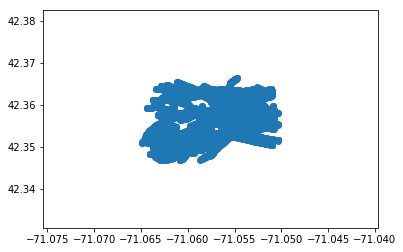

In [23]:
points = []
for r in roads:
    for i in range(len(r.nodes)-1):
        n1 = latlng.LatLng(r.nodes[i].lat, r.nodes[i].lng)
        n2 = latlng.LatLng(r.nodes[i+1].lat, r.nodes[i+1].lng)
        n = int(n1.get_distance(n2)/5.0)+1
        for j in range(n+1):
            p = latlng.LatLng(n1.lat + j*(n2.lat-n1.lat)/n, n1.lng + j*(n2.lng-n1.lng)/n)
            points.append(p)

print(len(points))
px = []
py = []
for p in points:
    px.append(p.lat)
    py.append(p.lng)
plt.scatter(py,px)
plt.show()